# Epipolar Geometry
 - **Part1:**
 find the matched points provided using SIFT and estimate the fundamental matrix F automatically using RANSAC and the normalized 8-point algorithm.

 - ref: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

Downloading...
From: https://drive.google.com/uc?id=1RNCdBF9a4fIdcyPvjelyx7dsheLgRoaQ
To: /content/leftSite.jpg
100% 576k/576k [00:00<00:00, 63.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zHAtikO9dVHpLPJ-KQPdvKEC-wLB1hHM
To: /content/rightSite.jpg
100% 554k/554k [00:00<00:00, 99.1MB/s]


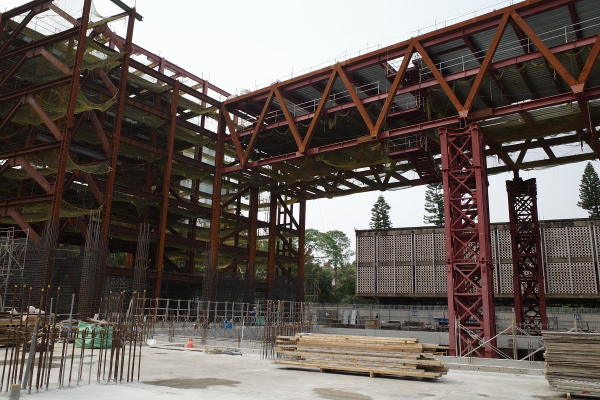

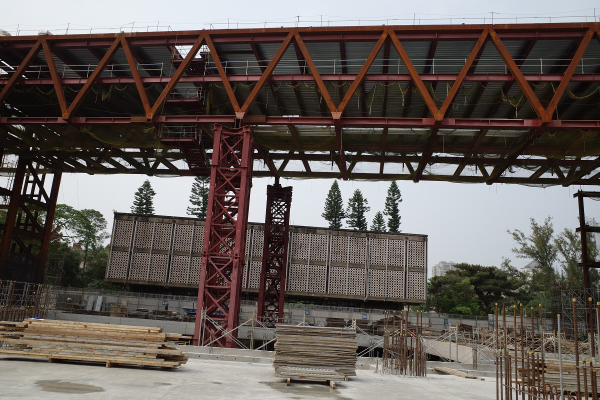

In [136]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

%matplotlib inline 
import matplotlib.pyplot as plt
import pylab, random 
pylab.rcParams['figure.figsize'] = (20, 15) 

#Download the left and right perspective of site images 
!gdown --id '1RNCdBF9a4fIdcyPvjelyx7dsheLgRoaQ' --output leftSite.jpg
img1 = cv2.imread('leftSite.jpg')
img1 = cv2.resize(img1, (int(img1.shape[1]*0.5),int(img1.shape[0]*0.5)))

!gdown --id '1zHAtikO9dVHpLPJ-KQPdvKEC-wLB1hHM' --output rightSite.jpg
img2  = cv2.imread('rightSite.jpg')
img2 = cv2.resize(img2, (int(img2.shape[1]*0.5),int(img2.shape[0]*0.5)))

cv2_imshow(img1)
cv2_imshow(img2)

In [137]:
# create a SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, queryDescriptors = sift.detectAndCompute(img1, None)
kp2, trainDescriptors = sift.detectAndCompute(img2, None)

# matching descriptor vectors with a FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(queryDescriptors, trainDescriptors, k=2)

queryKp = []
trainKp = []
# Filter matches using the Lowe's ratio test
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        queryKp.append(kp1[m.queryIdx].pt)
        trainKp.append(kp2[m.trainIdx].pt)

queryKp = np.int32(queryKp)
trainKp = np.int32(trainKp)

In [138]:
# using cv2.findFundamentalMat to estimate the fundamental matrix F automatically by RANSAC
F1, mask1 = cv2.findFundamentalMat( trainKp, queryKp,cv2.RANSAC)

# Display F1 after normalizing to unit length.
l1_norm = np.linalg.norm(F1)
F1 /= l1_norm
print(F1)

[[-7.23611532e-07  1.50068035e-05 -4.35324299e-03]
 [-1.30377217e-05 -1.94909382e-06  7.25257618e-04]
 [ 4.22390407e-03 -3.61711771e-03  9.99974799e-01]]


In [139]:
# using cv2.findFundamentalMat to estimate the fundamental matrix F automatically by 8-point algorithm
F2, mask2 = cv2.findFundamentalMat( queryKp, trainKp, cv2.FM_8POINT)

# Display F2 after normalizing to unit length.
l2_norm = np.linalg.norm(F2)
F2 /= l2_norm
print(F2)

[[-3.74073274e-06  2.27761458e-05 -6.78832423e-03]
 [ 4.40971121e-06  1.00206266e-06  1.54878189e-02]
 [ 2.00454224e-03 -2.20204228e-02  9.99612489e-01]]


In [140]:
# Indicate what test you used for deciding inlier vs. outlier.

# select inlier points
queryKp_inlier = queryKp[mask1.ravel()==1]
trainKp_inlier = trainKp[mask1.ravel()==1]

# select outlier points
queryKp_outlier = queryKp[mask1.ravel()!=1]
trainKp_outlier = trainKp[mask1.ravel()!=1]

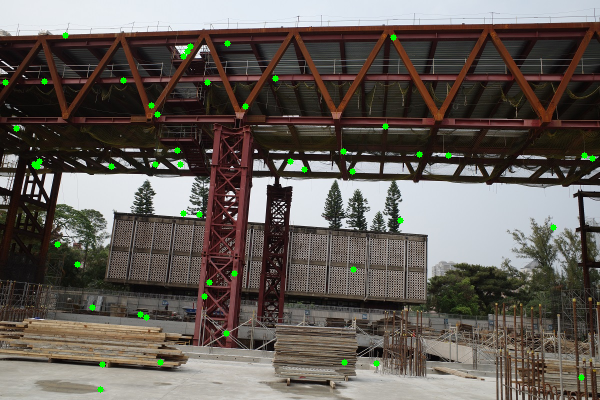

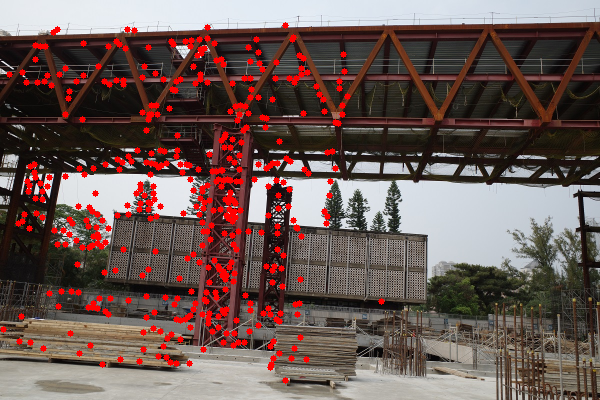

In [141]:
img2_kp = img2.copy()
# Plot the outliers with green dots of the trained image
for x, y in trainKp_outlier:
  cv2.circle(img2_kp, (x, y), 3, (0, 255, 0), -1)  
cv2_imshow(img2_kp)

img2_kp = img2.copy()
# Plot the inliers with red dots of the trained image
for x, y in trainKp_inlier:
  cv2.circle(img2_kp, (x, y), 3, (0, 0, 255), -1)  
cv2_imshow(img2_kp)

 - **Part2:** Choose 7 sets of matching points that are well separated (can be randomly chosen). 
Plot the corresponding epipolar lines and the points on each image. 
Show the two images (with plotted points and lines) next to each other.
 - ref: https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html

In [142]:
# Choose 7 sets of matching points that are well separated (can be randomly chosen)
def random_matches(pts1, pts2):
  pts_list = list(zip(pts1, pts2))
  random_sample_index = random.sample(set(np.arange(len(pts1))), 7)
  random_sample_pts1 = np.array([pts1[i] for i in random_sample_index])
  random_sample_pts2 = np.array([pts2[i] for i in random_sample_index]) 
  return random_sample_pts1, random_sample_pts2

selected_pts1, selected_pts2 = random_matches(queryKp_inlier, trainKp_inlier)

# This method computes and draws the epipolar lines and matching points of the two loaded images.
def drawlines(img1, img2, lines, pts1, pts2, colors):
    r, c, _ = img1.shape

    img1_draw = img1.copy()
    img2_draw = img2.copy()

    # Converting images from RGB to BGR
    img1_draw = cv2.cvtColor(img1_draw, cv2.COLOR_RGB2BGR)
    img2_draw = cv2.cvtColor(img2_draw, cv2.COLOR_RGB2BGR)

    for r, pt1, pt2, color in zip(lines, pts1, pts2, colors):

        # calculate start and end point of each epiline
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])

        # draw each epiline and its matching points
        img1_draw = cv2.line(img1_draw, (x0, y0), (x1, y1), color, 2)
        img1_draw = cv2.circle(img1_draw, tuple(pt1), 6, color, -1)

    return img1_draw

# Create 7 random colors 
colors = []
for i in range(7):
  colors.append(tuple(np.random.randint(0, 255, 3).tolist()))

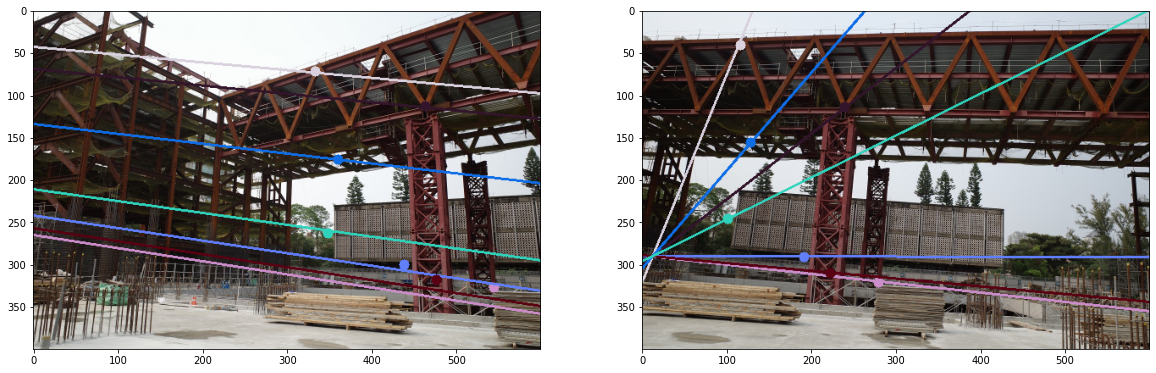

In [144]:
# Find epilines by cv2.computeCorrespondEpilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(selected_pts2.reshape(-1, 1, 2), 2, F2).reshape(-1, 3)
img5 = drawlines(img1, img2, lines1, selected_pts1, selected_pts2, colors)

# Find epilines by cv2.computeCorrespondEpilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(selected_pts1.reshape(-1, 1, 2), 2, F1).reshape(-1, 3)
img3 = drawlines(img2, img1, lines2, selected_pts2, selected_pts1, colors)

plt.subplot(121)
plt.imshow(img5)
plt.subplot(122)
plt.imshow(img3)
plt.show()